In [142]:
import os
import numpy as np
import random

def read_text_files(folder_path):
    """Reads all text files in the given folder."""
    contents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # Check if it's a file and has .txt extension
        if os.path.isfile(file_path) and filename.endswith(".txt"):
            with open(file_path, "r") as file:
                content = file.read()
                contents.append(content)
    return contents

In [143]:
# Training set
train_positive_reviews = read_text_files("data/aclImdb/train/pos/")
train_negative_reviews = read_text_files("data/aclImdb/train/neg/")
train_reviews = train_positive_reviews + train_negative_reviews
y_train = np.array([1]*12500 + [0]*12500)#.astype('int32')
#Test set
test_positive_reviews = read_text_files("data/aclImdb/test/pos/")
test_negative_reviews = read_text_files("data/aclImdb/test/neg/")
test_reviews = test_positive_reviews + test_negative_reviews
y_test = np.array([1]*12500 + [0]*12500)#.astype('int32')

In [144]:
from tensorflow.keras.preprocessing.text import Tokenizer

```markdown
The reviews are converted into tokens using the `Tokenizer()` class from Keras. The `fit_on_texts()` method is used to build the vocabulary based on the training reviews. After fitting, the `word_index` dictionary is created, which maps each word to a unique integer. Finally, the `texts_to_sequences()` method is used to convert the reviews into sequences of integers, where each integer represents a word in the review. These sequences are stored in the `sequence_train` variable.

To visualize the process, a directional map can be drawn as follows:

1. **Input Reviews** → Raw text data from `train_reviews`.
2. **Tokenizer Initialization** → `Tokenizer(num_words=vocabulory)` is created.
3. **Vocabulary Building** → `tokenizer.fit_on_texts(train_reviews)` generates the `word_index`.
4. **Tokenization** → `tokenizer.texts_to_sequences(train_reviews)` converts reviews into `sequence_train`.

In [145]:
vocabulory = 10000
tokenizer = Tokenizer(num_words=vocabulory)
tokenizer.fit_on_texts(train_reviews)

In [146]:
# Retrieve the word index dictionary from the tokenizer
word_index = tokenizer.word_index

In [147]:
sequence_train = tokenizer.texts_to_sequences(train_reviews)

In [148]:
print(sequence_train[0])

[309, 6, 3, 1069, 209, 9, 2161, 30, 1, 169, 55, 14, 46, 82, 5844, 41, 392, 110, 138, 14, 5340, 58, 4449, 150, 8, 1, 4988, 5924, 482, 69, 5, 261, 12, 2002, 6, 73, 2425, 5, 632, 71, 6, 5340, 1, 5, 2003, 1, 5925, 1534, 34, 67, 64, 205, 140, 65, 1230, 1, 4, 1, 223, 901, 29, 3022, 69, 4, 1, 5845, 10, 693, 2, 65, 1534, 51, 10, 216, 1, 387, 8, 60, 3, 1467, 3712, 800, 5, 3513, 177, 1, 392, 10, 1237, 30, 309, 3, 353, 344, 2974, 143, 130, 5, 7799, 28, 4, 126, 5340, 1467, 2373, 5, 309, 10, 532, 12, 108, 1468, 4, 58, 555, 101, 12, 309, 6, 227, 4174, 48, 3, 2232, 12, 9, 215]


ALIGN SEQUENCES

In [149]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
word_num = 20 #to truncate long sequences to shorter length
x_train = pad_sequences(sequence_train, maxlen = word_num)

In [150]:
x_train.shape

(25000, 20)

In [151]:
x_train[0]

array([  10,  532,   12,  108, 1468,    4,   58,  555,  101,   12,  309,
          6,  227, 4174,   48,    3, 2232,   12,    9,  215])

TRAIN VALIDATION SPLIT

In [152]:
n = x_train.shape[0]
rand_perm = np.random.permutation(n)
n_valid = int(n * 0.2)
labels_train = np.array(y_train)
x_valid = x_train[rand_perm[0:n_valid], :]
y_valid = labels_train[rand_perm[0:n_valid]]
x_train = x_train[rand_perm[n_valid:n], :]
y_train = labels_train[rand_perm[n_valid:n]]


In [153]:
word_index = tokenizer.word_index
sequences_test = tokenizer.texts_to_sequences(test_reviews)
word_num = 20
x_test = pad_sequences(sequences_test, maxlen=word_num)

In [154]:
from keras.layers import Flatten, Embedding, Dense, Input
from keras.models import Sequential


embedding_dim = 8
model = Sequential()
model.add(Input((word_num, )))
model.add(Embedding(vocabulory, embedding_dim))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))
model.summary()


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 20, 8)          │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,161 (313.13 KB)

 Trainable params: 80,161 (313.13 KB)

 Non-trainable params: 0 (0.00 B)

In [155]:
from keras import optimizers

model.compile(optimizer = optimizers.RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy', metrics=['accuracy'])

In [156]:
history = model.fit(x_train,y_train, epochs= 50, batch_size=32, validation_data=(x_valid,y_valid))

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5056 - loss: 0.6930 - val_accuracy: 0.5196 - val_loss: 0.6920
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5491 - loss: 0.6907 - val_accuracy: 0.5446 - val_loss: 0.6901
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5844 - loss: 0.6879 - val_accuracy: 0.5808 - val_loss: 0.6872
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6247 - loss: 0.6834 - val_accuracy: 0.6160 - val_loss: 0.6827
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6654 - loss: 0.6771 - val_accuracy: 0.6404 - val_loss: 0.6760
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6822 - loss: 0.6690 - val_accuracy: 0.6608 - val_loss: 0.6670
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7019 - loss: 0.6576 - val_accuracy: 0.6766 - val_loss: 0.6555
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7114 - loss: 0.6448 - val_accuracy: 0.

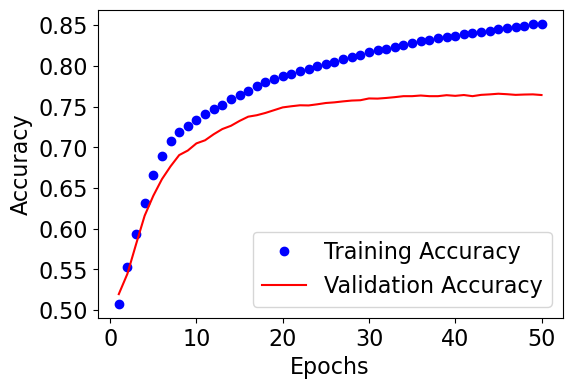

In [157]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))
epochs_list = list(range(1, 51))  # Corrected to create a list of epoch numbers
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
plt.plot(epochs_list, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs_list, valid_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

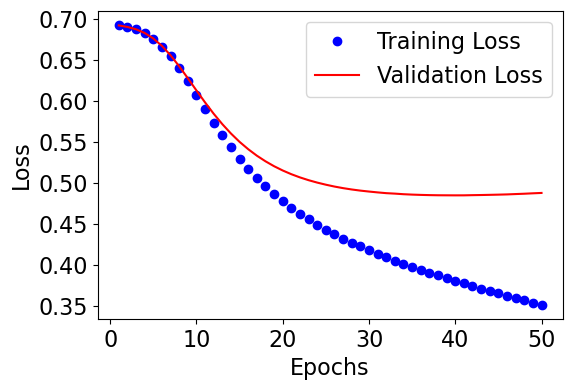

In [158]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))
epochs_list = list(range(1, 51))  # Create a list of epoch numbers
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(epochs_list, train_loss, 'bo', label='Training Loss')
plt.plot(epochs_list, valid_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [159]:
loss_and_acc = model.evaluate(x_test, y_test)
print('loss = ' + str(loss_and_acc[0]))
print('acc = ' + str(loss_and_acc[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7783 - loss: 0.4696
loss = 0.4813636243343353
acc = 0.7668399810791016
